In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RCurl)
library(kknn)
library(cowplot)
options(repr.matrix.max.rows = 6)
set.seed(1)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────── tidymodels_conflict

In [5]:
# Read the data from the web into jupyter
x <- getURL("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv")
data <- read.csv(text = x)

In [6]:
# Overview of the original dataset
data

track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,⋯,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxury Remix,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury Remix],2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,⋯,6,-2.634,1,0.0583,0.1020,0.00e+00,0.0653,0.518,122.036,194754
0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,⋯,11,-4.969,1,0.0373,0.0724,4.21e-03,0.3570,0.693,99.972,162600
1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,⋯,1,-3.432,0,0.0742,0.0794,2.33e-05,0.1100,0.613,124.008,176616
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,14,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),2014-04-21,â™¥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,⋯,6,-4.899,0,0.0481,0.108000,1.11e-06,0.150,0.4360,127.989,210112
2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,15,1fGrOkHnHJcStl14zNx8Jy,Only For You (Remixes),2014-01-01,â™¥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,⋯,2,-3.361,1,0.1090,0.007920,1.27e-01,0.343,0.3080,128.008,367432
29zWqhca3zt5NsckZqDf6c,Typhoon - Original Mix,Julian Calor,27,0X3mUOm6MhxR7PzxG95rAo,Typhoon/Storm,2014-03-03,â™¥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,⋯,5,-4.571,0,0.0385,0.000133,3.41e-01,0.742,0.0894,127.984,337500


**Table 1.1** - Original dataset

In [7]:
# Tidy the data, only keep the releveant columns
tidy_data <- data |>
            select(playlist_genre, danceability:tempo)
# Change datatype of match_result from character to factor in order for the next few functions to work 
# and successfully classify if it's a win or lose
tidy_data$playlist_genre <- as.factor(tidy_data$playlist_genre)
#TEMPORARY TAKE ONLY 5000 ROWS SO THE CODE RUNS FASTER, USE ALL THE DATA LATER
#tidy_data <- initial_split(tidy_data, prop = 0.15, strata = playlist_genre)|>
#               training()
tidy_data

playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.00e+00,0.0653,0.518,122.036
pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,4.21e-03,0.3570,0.693,99.972
pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,2.33e-05,0.1100,0.613,124.008
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
edm,0.529,0.821,6,-4.899,0,0.0481,0.108000,1.11e-06,0.150,0.4360,127.989
edm,0.626,0.888,2,-3.361,1,0.1090,0.007920,1.27e-01,0.343,0.3080,128.008
edm,0.603,0.884,5,-4.571,0,0.0385,0.000133,3.41e-01,0.742,0.0894,127.984


**Table 1.2** - Tidy dataset

In [8]:
# Split the data into training and testing sets at 75:25 ratio

set.seed(1) # Set the seed for reproducability
split_data <- initial_split(tidy_data, prop = 0.75, strata = playlist_genre)

# training set
train_data <- training(split_data)

# testing set
test_data <- testing(split_data)

In [9]:
# Preliminary data analysis

#Check number of missing values in each column of the table in the training data
num_na <- train_data|> 
            summarize_all(~sum(is.na(.))) 
num_na

playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0


**Table 1.3** - Preliminary data analysis

In [10]:
# Preliminary data visualization

**Table 1.4** - Preliminary data 

In [11]:
# Building the classifier/regressor 
# Scale predictors, use standard recipe, setup knn_spec to tune for best k value
data_recipe <- recipe(playlist_genre ~ ., data = train_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [12]:
#trying 15 different k values, count by every 10 from 1 to 51

set.seed(1)

k_vals <- tibble(neighbors = seq(from = 1, to = 51, by = 10))

data_vfold <- vfold_cv(train_data, v = 5, strata = playlist_genre)

knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

In [14]:
# Accuracy table for different k values
accuracies |>  arrange(desc(mean))

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,accuracy,multiclass,0.4849506,5,0.005409901,Preprocessor1_Model5
51,accuracy,multiclass,0.4847882,5,0.005032700,Preprocessor1_Model6
31,accuracy,multiclass,0.4843824,5,0.005472263,Preprocessor1_Model4
21,accuracy,multiclass,0.4793856,5,0.005437704,Preprocessor1_Model3
11,accuracy,multiclass,0.4730514,5,0.003223286,Preprocessor1_Model2
1,accuracy,multiclass,0.4209050,5,0.003307323,Preprocessor1_Model1


**Table 2.1** - Accuracy of the different k values

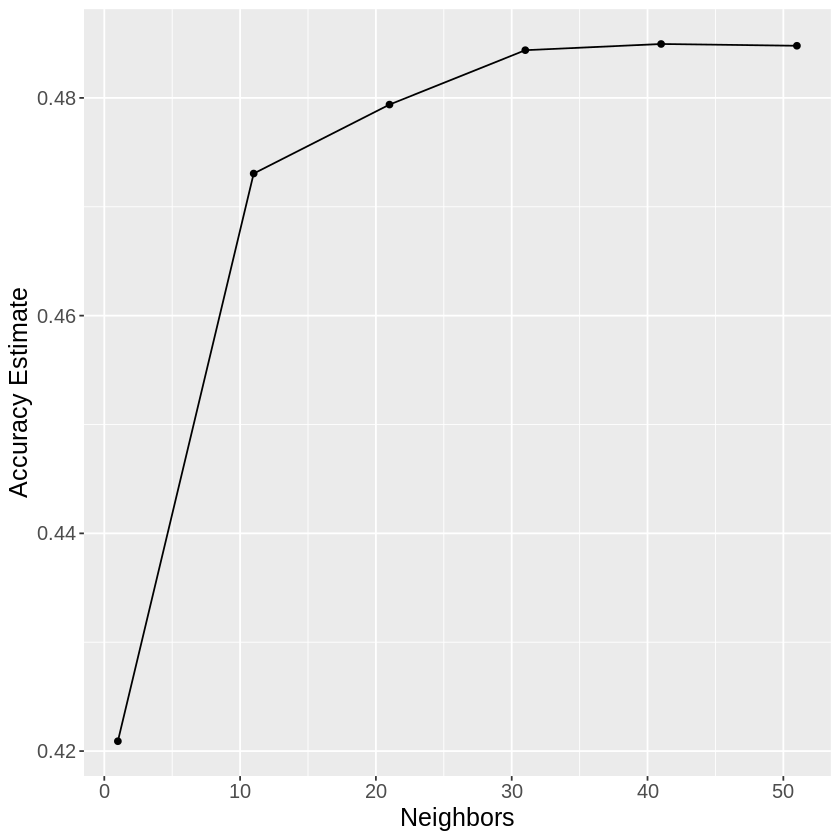

In [15]:
# Plot the different accuracies of k, 
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 15))

accuracy_vs_k

**Figure 2.2** - Plot of accuracies of the different k

In [16]:
# Calculate accuracy of the model using the best k and cross-validation

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = data_vfold)

accuracy_value <- knn_fit |> 
  collect_metrics() 

In [17]:
# Display accuracy of the model
accuracy_value

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.4730514,5,0.003223286,Preprocessor1_Model1
roc_auc,hand_till,0.7747687,5,0.003256340,Preprocessor1_Model1


**Table 2.3** - Accuracy of the model

In [18]:
#test predictions using test-data
knn_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  fit(train_data)

data_test_predictions <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

accuracy_only <- data_test_predictions |>
  metrics(truth = playlist_genre, estimate = .pred_class) |>
  filter(.metric == "accuracy")


confusion <- data_test_predictions |>
             conf_mat(truth = playlist_genre, estimate = .pred_class)

In [19]:
# Accuracy of the model on testing data
accuracy_only

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4684531


**Table 2.4** - Accuracy of model on testing data

In [20]:
# A table of predictions of the model
data_test_predictions

.pred_class,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pop,pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.00000,0.0653,0.518,122.036
latin,pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.00421,0.3570,0.693,99.972
edm,pop,0.449,0.856,5,-4.788,0,0.0623,0.1870,0.00000,0.1760,0.152,112.648
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
pop,edm,0.645,0.832,2,-5.595,1,0.0294,0.00106,2.64e-03,0.199,0.375,112.028
edm,edm,0.581,0.640,5,-8.367,1,0.0365,0.02660,0.00e+00,0.572,0.288,128.001
edm,edm,0.529,0.821,6,-4.899,0,0.0481,0.10800,1.11e-06,0.150,0.436,127.989


In [21]:
# Confusion
confusion

          Truth
Prediction edm latin pop r&b rap rock
     edm   952   146 277  74 122  111
     latin 105   475 181 170 184   49
     pop   215   221 391 203 100  139
     r&b    60   178 190 483 207  126
     rap    81   178 114 296 771   39
     rock   98    91 224 132  53  774

In [18]:
# Data visualization 

In [19]:
# Forward Selection?

In [20]:
# Discussion